![ph_1](photos/ph_1.png)

Przedmiot:      **Systemy Dedykowane W Układach Programowalnych**

Autorzy:
* **Wiktor Pantak**
          
* **Jan Rudecki**

## Wstęp

Celem projektu było zaimplementowanie **szeregu Taylora** dla funkcji Sinus na FPGA **Zybo Zynq-7000 ARM/FPGA SoC Trainer Board**.
Wykorzystywanym oprogramowaniem było Vivado 2023.2.2 oraz środowisko Pynq przystosowane na używaną płytkę.

## Płytka Zynq-7000 ARM/FPGA SoC Trainer Board

![ph_0](photos/ph_0.png)

![ph_0](photos/ph_6.png)

__ZYBO__ (**ZY**nq **BO**ard) to bogate w funkcje, gotowe do użycia, podstawowe oprogramowanie wbudowane i platforma rozwoju obwodów cyfrowych, zbudowana wokół najmniejszego członka rodziny Xilinx Zynq-7000, Z-7010. Z-7010 jest oparty na architekturze Xilinx All Programmable System-on-Chip (AP SoC), która ściśle integruje dwurdzeniowy procesor ARM Cortex-A9 z logiką Xilinx 7-series Field Programmable Gate Array (FPGA).

## Implementacja Szeregu Taylora

Szereg Taylora jest przedstawieniem funckji różniczkowalnej za pomocą sumy wielomianu n-tego stopnia.
Poniżej znajduje się wykorzystany wzór szeregu Taylora dla Sinusa w naszej implementacji.

![ph_2](photos/ph_2.png)

Pierwotny pomysł implementacji został pzedstawiony na poniższym schemacie, zawiera on nastepujące funkcjonalne bloki:


* __*__    - Mnożenie
* __+__    - Dodawanie

Dodatkowo w tabeli są przedstawione wartości początkowe potrzebne w kolejnych iteracjach algorytmu, zmienna x przedstawia dane wejściowe.


![ph_3](photos/ph_3.png)

Ostatecznie w implementacji wykorzystano pierwsze 4 iteracje, jest to spowodowane precyzją zmiennych, gdyż wykorzystujemy fixed point[12:10] i po piątej iteracji traciliśmy dokładność.

Ostateczna implementacja w języku System Verilog jest przedstawiona poprzez poniższą maszynę stanów:

![ph_4](photos/ph_4.png)



Algorytm uruchamia się w momencie kiedy start_in wynosi 1, iteruje się łącznei 5 razy, z czego pierwsza iteracja następuje przed pętlą, są przygotowane zmienne, o dwa razy większej ilosci bitów, w celu przechowywania wyników mnożeń (zmienne _mul).
Wartośc x_in jest przekazywana do algorytmu w formacie FXP[12:10], a następnie przypisywana do zmiennej x_base.
Wynik końcowy jest przypisywany do zmiennej sin_out, zmienna ready_out ustawia stan na "1" przez co informuje o zakończeniu algorytmu.



Całośc implementacji znajduje sie w repozytrium github, pod linkiem: https://github.com/janek252/FPGA_taylor_aproximation.git

## Wyniki symulacji algorytmu

![ph_5](photos/ph_5.png)

Symulacja przedatwia zmiany kątów w zakresie od 0&deg; do 45&deg;, umożliwia to zaobserwowania rzeczywistej wartości sinusa (**sin_expected**) oraz implementacji sprzętowej sinusa (**sin_actual**).
Przedstawiono również procentowe pokrycie **sin_actual** przez **sin_expected** poprzez zmienną **delta**. 

## Implementacja sprzętowa

![ph_7](photos/ph_7.png)

W implementacji sprzętowej wykorzystano wymagane bloki:
* **ZYNQ7 Processing System** - odpowiada za procesor ARM 
* **AXI Interconnect** - magistrala AXI, wymagana do podłaczenia procesora do taylor_ip
* **Processor System Reset** - system resetowania procesora
* **taylor_ip_v1.2** - implementacja hardware szeregu Taylora

W celu umożliwienia wykorzystania rejestrów w bloku taylor_ip_v1.2 konieczne było ręczne dodanie ich tak jak na zdjęciu poniżej:

![ph_9](photos/ph_9.png)

Prezentacja layoutu implementacji bramek:

![ph_8](photos/ph_8.png)

## Implementacja w środowisku PYNQ

Import Bibliotek:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

Załadowanie pliku .xsa

In [8]:

from pynq import Overlay
zybo_taylor_ov = Overlay("zybo_taylor_wrapper_final.xsa")


Przypisanie rejestrów do zmiennej oraz ich wyświetlenie:

In [9]:
taylor_seq = zybo_taylor_ov.taylor_ip_0.register_map
print(taylor_seq)

RegisterMap {
  slv_reg0 = Register(value=0),
  slv_reg1 = Register(value=0),
  slv_reg2 = Register(value=0),
  slv_reg3 = Register(value=0)
}


Następujące rejestry odpowiadają nastepującym zmiennym maszyny stanów implementacji:
* **slv_reg0** odpowiada start_in
* **slv_reg1** odpowiada x_in
* **slv_reg2** odpowiada ready_out
* **slv_reg3** odpowiada sin_out

## Test Implementacji oraz wyświetlenie wyników: 

Algorytm porównuje wartości funkcji sinus obliczane za pomocą biblioteki NumPy z wartościami obliczanymi przez sprzęt. Działa na kątach w zakresie od 5° do 60°, obliczając wartość sinus dla każdego kąta zarówno za pomocą NumPy, jak i sprzętu. Następnie porównuje wyniki, wyznaczając różnice procentowe i numeryczne.

### Najważniejsze zmienne

- `angles_deg`: Tablica kątów w stopniach (od 5° do 60° z krokiem 5°).
- `sin_numpy`: Wartość sinusa obliczona za pomocą NumPy dla `angle_rad`.
- `angle_fxp`: Wartość kąta skonwertowana na wartość stałoprzecinkową.
- `sin`: Surowa wartość sinusa odczytana ze sprzętu.
- `sin_hardware`: Wartość sinusa obliczona przez sprzęt po przeskalowaniu.

### Przebieg algorytmu

1. **Inicjalizacja**: Ustalenie list do przechowywania wyników.
2. **Pętla po kątach**:
    - Dla każdego kąta:
        - Obliczenie wartości sinus za pomocą NumPy.
        - Konwersja kąta na wartość stałoprzecinkową.
        - Ustawienie odpowiednich rejestrów sprzętowych.
        - Odczyt wartości sinus ze sprzętu.
        - Obliczenie różnic procentowych i numerycznych między wynikami NumPy a sprzętem.
        - Zapisanie wyników do list.
3. **Rysowanie wykresu**: Porównanie wyników za pomocą wykresu


In [10]:

angles_deg = np.linspace(5, 60, 12).astype(int)

# Listy do przechowywania wyników
angles = []
sin_numpy_values = []
sin_hardware_values = []
blad_bezwzgledny_values = []
blad_wzgledny_values = []

for angle_deg in angles_deg:
    print("Badany kąt: ", angle_deg, "°")
    angle_rad = np.deg2rad(angle_deg)
    
    # Obliczanie wartości sinus za pomocą NumPy
    sin_numpy = np.sin(angle_rad)
    print("sin_numpy", sin_numpy)
    
    # Konwersja kąta na wartość stałoprzecinkową
    angle_fxp = (int(1024 * angle_deg * 1024 * np.pi) >> 10) / 180
    
    # Ustawienia rejestrów sprzętowych
    taylor_seq.slv_reg1 = angle_fxp + 0
    taylor_seq.slv_reg0 = 1
    
    # Odczyt wartości sinus ze sprzętu
    sin = ((int(taylor_seq.slv_reg3) & 0x00000FFF) << 20) >> 20
    sin_hardware = sin / 1024
    print("sin_taylor", sin_hardware)
    
    # Wyznaczanie błędu względnego i bezwzględnego
    taylor_seq.slv_reg0 = 0
    sin_blad_bezwzgledny = sin_hardware - sin_numpy
    sin_blad_wzgledny = sin_blad_bezwzgledny / sin_numpy * 100
    print("blad bezwzgledny = ", sin_blad_bezwzgledny)
    print("blad wzgledny = ", sin_blad_wzgledny)
    print("-----------------------------------")
    
    # Zapisanie wyników do list
    angles.append(angle_deg)
    sin_numpy_values.append(sin_numpy)
    sin_hardware_values.append(sin_hardware)
    blad_bezwzgledny_values.append(sin_blad_bezwzgledny)
    blad_wzgledny_values.append(sin_blad_wzgledny)



Badany kąt:  5 °
sin_numpy 0.08715574274765817
sin_taylor 0.0859375
blad bezwzgledny =  -0.0012182427476581659
blad wzgledny =  -1.3977767950246738
-----------------------------------
Badany kąt:  10 °
sin_numpy 0.17364817766693033
sin_taylor 0.171875
blad bezwzgledny =  -0.0017731776669303312
blad wzgledny =  -1.0211323209687884
-----------------------------------
Badany kąt:  15 °
sin_numpy 0.25881904510252074
sin_taylor 0.2578125
blad bezwzgledny =  -0.0010065451025207395
blad wzgledny =  -0.38889916393982416
-----------------------------------
Badany kąt:  20 °
sin_numpy 0.3420201433256687
sin_taylor 0.3408203125
blad bezwzgledny =  -0.001199830825668713
blad wzgledny =  -0.3508070647541493
-----------------------------------
Badany kąt:  25 °
sin_numpy 0.42261826174069944
sin_taylor 0.4208984375
blad bezwzgledny =  -0.0017198242406994413
blad wzgledny =  -0.40694508410870617
-----------------------------------
Badany kąt:  30 °
sin_numpy 0.49999999999999994
sin_taylor 0.4990234375

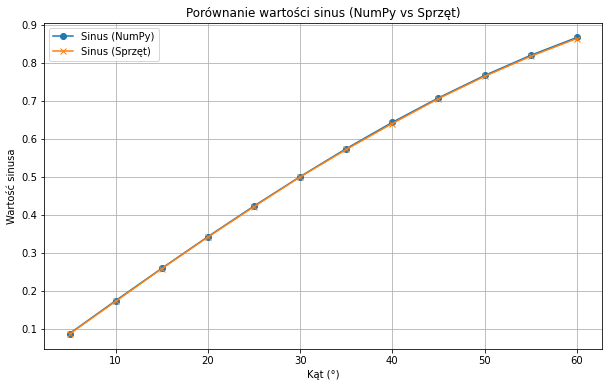

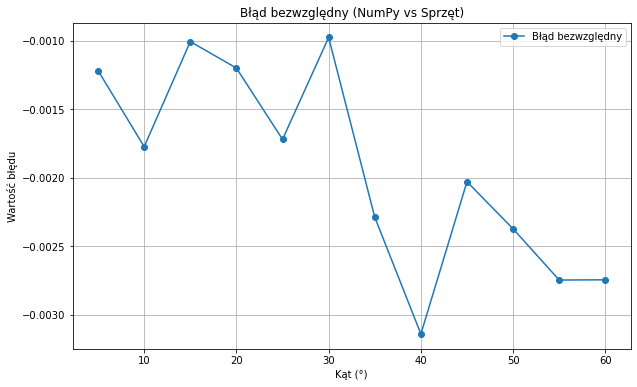

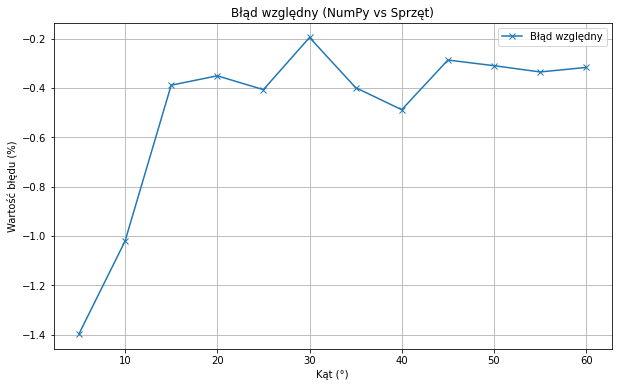

In [11]:
# Rysowanie wykresu
plt.figure(0,figsize=(10, 6))
plt.plot(angles, sin_numpy_values, label="Sinus (NumPy)", marker='o')
plt.plot(angles, sin_hardware_values, label="Sinus (Sprzęt)", marker='x')
plt.xlabel("Kąt (°)")
plt.ylabel("Wartość sinusa")
plt.title("Porównanie wartości sinus (NumPy vs Sprzęt)")
plt.legend()
plt.grid(True)

plt.figure(1, figsize=(10, 6))
plt.plot(angles, blad_bezwzgledny_values, label="Błąd bezwzględny", marker='o')
plt.xlabel("Kąt (°)")
plt.ylabel("Wartość błędu")
plt.title("Błąd bezwzględny (NumPy vs Sprzęt)")
plt.legend()
plt.grid(True)

plt.figure(2, figsize=(10, 6))
plt.plot(angles, blad_wzgledny_values, label="Błąd względny", marker='x')
plt.xlabel("Kąt (°)")
plt.ylabel("Wartość błędu (%)")
plt.title("Błąd względny (NumPy vs Sprzęt)")
plt.legend()
plt.grid(True)

plt.show()


## Bibliografia

* https://digilent.com/reference/programmable-logic/zybo/start?redirect=1
* https://people.math.sc.edu/girardi/m142/handouts/10sTaylorPolySeries.pdf
* https://pl.wikipedia.org/wiki/Wz%C3%B3r_Taylora
* https://discuss.pynq.io/t/registers-addressing-for-hwh-file/1667
* Custom system design in FPGA laboratory Tutorial 2 Simulation of the AXI-based accelerated system - Paweł Russek ver. 2021.03.23

* CUSTOM SYSTEM DESIGN IN FPGA LABORATORY PYNQ - introduction ver 0.2.1